In [28]:
#安裝套件
!pip install torch>=2.1.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pytorch-lightning==2.5.0
!pip install ultralytics pytesseract
!pip install easyocr

In [7]:
'''步驟總覽
設定 Kaggle Notebook 環境
下載並準備資料集
轉換標註格式為 YOLO
建立 data.yaml 設定檔
下載 YOLOv8 並訓練模型
測試訓練好的模型'''

'步驟總覽\n設定 Kaggle Notebook 環境\n下載並準備資料集\n轉換標註格式為 YOLO\n建立 data.yaml 設定檔\n下載 YOLOv8 並訓練模型\n測試訓練好的模型'

In [29]:
import os

dataset_path = "/kaggle/input/car-plate-detection"

print("📂 檢查資料集內容:", os.listdir(dataset_path))


📂 檢查資料集內容: ['annotations', 'images']


In [30]:
os.makedirs("/kaggle/working/images/train", exist_ok=True)
print("資料夾建立成功")

資料夾建立成功


In [31]:
import os
import glob
import shutil
import xml.etree.ElementTree as ET

# ✅ 確保類別名稱和 data.yaml 一致
classes = ["licence"]  # 注意: 確保 data.yaml 內也是 "licence"

# ✅ 設定標註與影像路徑
annotation_dir = "/kaggle/input/car-plate-detection/annotations"
image_dir = "/kaggle/input/car-plate-detection/images"
output_img_dir = "/kaggle/working/images/train"
output_label_dir = "/kaggle/working/labels/train"

# ✅ 確保輸出資料夾存在
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

def convert_xml_to_yolo_and_copy_images(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    img_filename = root.find("filename").text
    img_path = os.path.join(image_dir, img_filename)

    # ✅ 檢查影像是否存在
    if not os.path.exists(img_path):
        print(f"⚠️ 影像檔案不存在：{img_path}，跳過！")
        return

    # 複製影像到目標資料夾
    output_img_path = os.path.join(output_img_dir, img_filename)
    shutil.copy(img_path, output_img_path)

    # ✅ 讀取影像大小
    size = root.find("size")
    img_w = int(size.find("width").text)
    img_h = int(size.find("height").text)

    yolo_annotations = []

    for obj in root.findall("object"):
        label = obj.find("name").text
        if label not in classes:
            print(f"⚠️ {img_filename} 的標註 `{label}` 未包含在 classes 清單內，已跳過")
            continue
        
        class_id = classes.index(label)
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # ✅ 轉換為 YOLO 格式 (相對座標)
        x_center = (xmin + xmax) / 2 / img_w
        y_center = (ymin + ymax) / 2 / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # ✅ 確保 `.txt` 檔案名稱對應影像名稱
    txt_filename = os.path.splitext(img_filename)[0] + ".txt"
    txt_file = os.path.join(output_label_dir, txt_filename)

    if yolo_annotations:
        with open(txt_file, "w") as f:
            f.write("\n".join(yolo_annotations))
    else:
        print(f"⚠️ {txt_filename} 無有效標註，已跳過")

# 🔄 開始轉換 XML 並複製影像
xml_files = glob.glob(f"{annotation_dir}/*.xml")
for xml in xml_files:
    convert_xml_to_yolo_and_copy_images(xml)

print("✅ XML 轉換及影像複製完成！")


✅ XML 轉換及影像複製完成！


In [32]:
yaml_content = """\
train: /kaggle/working/images/train
val: /kaggle/working/images/train

nc: 1
names: ['licence']
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml 設定檔已建立！")


✅ data.yaml 設定檔已建立！


In [33]:
from ultralytics import YOLO

# 下載 YOLOv8 預訓練權重
model = YOLO("yolov8n.pt")

# 訓練 YOLO
model.train(data="/kaggle/working/data.yaml", epochs=100, imgsz=640)


New https://pypi.org/project/ultralytics/8.3.73 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.72 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning /kaggle/working/labels/train.cache... 433 images, 0 backgrounds, 0 corrupt: 100%|██████████| 433/433 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/labels/train.cache... 433 images, 0 backgrounds, 0 corrupt: 100%|██████████| 433/433 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.38G      1.514      2.824      1.287          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.61it/s]


                   all        433        471      0.965      0.176       0.56      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.25G      1.571      1.955      1.252          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.47it/s]


                   all        433        471      0.319      0.108     0.0968     0.0417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.21G      1.517      1.812       1.26          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]


                   all        433        471      0.659      0.423      0.488      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.22G      1.535      1.646      1.321          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]


                   all        433        471      0.403       0.41      0.287      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.22G      1.515      1.554      1.275          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]


                   all        433        471      0.788      0.796      0.829      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.22G      1.489       1.44      1.293          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]


                   all        433        471      0.815      0.562      0.674       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.21G      1.501      1.309      1.282          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.61it/s]


                   all        433        471      0.636      0.659      0.656      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.22G      1.502      1.331       1.27          4        640: 100%|██████████| 28/28 [00:05<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.77it/s]


                   all        433        471      0.762      0.766      0.807      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.22G       1.45      1.229      1.253          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]


                   all        433        471      0.692      0.631      0.681      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.26G      1.472      1.169      1.284          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.76it/s]


                   all        433        471      0.819      0.794      0.862      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.21G      1.398      1.117      1.224          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]


                   all        433        471      0.731      0.762      0.821      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.21G      1.369      1.068      1.219          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

                   all        433        471      0.817      0.777      0.846      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.21G       1.39     0.9897      1.195          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]

                   all        433        471      0.871      0.771      0.863      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.21G      1.427      1.023      1.208          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]

                   all        433        471      0.872      0.784      0.876      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.21G      1.395      1.014      1.215          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]

                   all        433        471      0.887      0.868      0.933      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.21G      1.356     0.9356      1.195          3        640: 100%|██████████| 28/28 [00:06<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        433        471      0.854      0.856      0.919      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.21G       1.39     0.9187       1.21          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.49it/s]

                   all        433        471      0.923      0.889      0.951      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.21G       1.38     0.9445      1.216          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]

                   all        433        471      0.896      0.859      0.923      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.21G      1.301     0.9132      1.184          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.71it/s]

                   all        433        471      0.876      0.869      0.907      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.21G       1.34     0.8835      1.215          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]

                   all        433        471      0.887      0.881      0.928      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.21G      1.304      0.862       1.18          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]

                   all        433        471      0.899      0.868      0.924      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.23G      1.332     0.8678      1.183          3        640: 100%|██████████| 28/28 [00:06<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]

                   all        433        471      0.854       0.87      0.915      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.21G      1.294     0.8412      1.157          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

                   all        433        471      0.811      0.866      0.908      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.21G        1.3     0.8817      1.164          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        433        471       0.91      0.863      0.925      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.21G      1.293     0.8015      1.146          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.75it/s]

                   all        433        471      0.931      0.892      0.954      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.21G      1.265     0.8172      1.158          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]

                   all        433        471        0.9      0.901      0.948      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.21G      1.241     0.8303      1.136          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.47it/s]

                   all        433        471      0.899        0.9      0.951      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.21G      1.289     0.8377      1.146          5        640: 100%|██████████| 28/28 [00:05<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

                   all        433        471      0.894       0.89      0.931      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.21G      1.251     0.8293      1.194          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

                   all        433        471      0.906      0.913       0.93      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.21G      1.235     0.8119      1.126          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

                   all        433        471       0.92      0.913      0.951      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.21G      1.311     0.8175      1.153          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.44it/s]

                   all        433        471      0.912      0.885      0.953      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.21G      1.204     0.7717      1.148          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.50it/s]

                   all        433        471      0.928      0.941      0.964      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.21G      1.246      0.748      1.157          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.82it/s]

                   all        433        471      0.908       0.93      0.943      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.21G      1.299     0.7735      1.142          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]

                   all        433        471      0.923      0.942      0.968      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.21G      1.183     0.7352      1.119          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        433        471      0.949      0.962      0.973      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.21G      1.155     0.7459      1.099          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.47it/s]

                   all        433        471       0.91      0.961      0.972      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.21G      1.187     0.7071      1.128          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.22it/s]

                   all        433        471      0.941      0.941      0.969      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.21G      1.175     0.7131      1.093          0        640: 100%|██████████| 28/28 [00:06<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]

                   all        433        471      0.929      0.946       0.97      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.21G      1.231     0.7289      1.157          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]

                   all        433        471      0.896      0.955      0.961      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.21G       1.19     0.7297      1.118          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]

                   all        433        471      0.946      0.958      0.976      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.21G      1.198      0.831      1.147          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]

                   all        433        471      0.948      0.943      0.973      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.21G      1.233     0.7266      1.165          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]

                   all        433        471      0.956       0.93      0.974      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.21G      1.135     0.7007      1.095          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]

                   all        433        471       0.94      0.934      0.971      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.21G      1.177     0.6914       1.11          3        640: 100%|██████████| 28/28 [00:06<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        433        471      0.933      0.941      0.964      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.21G      1.165     0.7192      1.097          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]

                   all        433        471      0.946       0.96       0.97      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.21G      1.131     0.6869      1.102          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        433        471      0.936      0.941      0.979      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.21G      1.118     0.6687      1.105          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

                   all        433        471       0.91      0.942      0.965      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.21G      1.151     0.6724      1.115          3        640: 100%|██████████| 28/28 [00:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]

                   all        433        471      0.927      0.964      0.973      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.21G      1.105     0.6614      1.085          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        433        471      0.942      0.968      0.973      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.21G      1.139     0.6909      1.091          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]

                   all        433        471      0.934      0.959      0.966      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.21G      1.106     0.6263      1.093          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

                   all        433        471      0.949      0.968      0.975      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.21G       1.14     0.7354      1.087          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.82it/s]

                   all        433        471      0.934      0.975      0.978      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.21G      1.126     0.6575      1.082          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

                   all        433        471      0.931      0.968      0.972      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.21G      1.096     0.6508      1.063          3        640: 100%|██████████| 28/28 [00:06<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]

                   all        433        471      0.923      0.975      0.978       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.21G      1.082     0.6205      1.072          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]

                   all        433        471      0.952      0.978      0.984      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.21G      1.118     0.7597      1.107          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.54it/s]

                   all        433        471      0.956      0.969      0.982      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.21G      1.094     0.6452      1.081          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]

                   all        433        471       0.95      0.977      0.984      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.21G       1.12     0.6399      1.091          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]

                   all        433        471      0.948      0.971      0.981      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.21G      1.077     0.6433      1.048          0        640: 100%|██████████| 28/28 [00:06<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]

                   all        433        471      0.946      0.971      0.981      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.23G      1.004      0.602      1.056          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]

                   all        433        471       0.96      0.972      0.984      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.21G      1.085     0.6202      1.068          3        640: 100%|██████████| 28/28 [00:06<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.86it/s]

                   all        433        471      0.946      0.985      0.984      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.21G      1.038     0.6095      1.043          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.82it/s]

                   all        433        471      0.965      0.962      0.987      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.21G      1.046     0.5846      1.056          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.47it/s]

                   all        433        471      0.956      0.975      0.982      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.21G      1.059      0.582      1.052          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]

                   all        433        471       0.96       0.97      0.986      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.23G      1.027     0.5828       1.04          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]

                   all        433        471      0.949      0.985      0.988      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.21G      1.081     0.5719      1.061          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]

                   all        433        471      0.946      0.985      0.987      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.21G      1.022     0.5632      1.029          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.53it/s]

                   all        433        471      0.941      0.981      0.988      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.21G      1.028     0.5734      1.058          3        640: 100%|██████████| 28/28 [00:06<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]

                   all        433        471      0.951      0.987      0.988      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.21G      1.011     0.5652      1.057          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]

                   all        433        471      0.954      0.979      0.989      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.21G      1.019     0.5571      1.046          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.71it/s]

                   all        433        471      0.949      0.983      0.987       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.21G       1.03     0.5641      1.049          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.85it/s]

                   all        433        471       0.96      0.977      0.987      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.21G     0.9866      0.555      1.047          3        640: 100%|██████████| 28/28 [00:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]

                   all        433        471      0.957      0.983      0.988      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.21G      1.006      0.551      1.034          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]

                   all        433        471      0.951      0.983       0.99      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.21G      1.001     0.5443      1.037          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]

                   all        433        471      0.958      0.976      0.989      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.21G       1.01     0.5668      1.036          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.50it/s]

                   all        433        471      0.966      0.968       0.99      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.21G     0.9431     0.5503      1.026          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]

                   all        433        471      0.951      0.983      0.988       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.21G      1.009     0.5368      1.037          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

                   all        433        471      0.964       0.97      0.988      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.21G      0.991     0.5446      1.042          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]

                   all        433        471      0.955      0.985      0.988      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.21G     0.9973     0.5515      1.037          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]

                   all        433        471      0.964      0.975      0.988      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.21G      0.977     0.5355      1.042          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.76it/s]

                   all        433        471      0.971       0.97      0.989      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.21G      0.934     0.5194      1.014          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.81it/s]

                   all        433        471      0.962      0.983      0.991       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.21G      0.976     0.5219       1.03          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]

                   all        433        471      0.969       0.97       0.99      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.21G     0.9568       0.52      1.024          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.69it/s]

                   all        433        471      0.969      0.975       0.99       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.21G     0.8963     0.5055     0.9885          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        433        471       0.97      0.975       0.99       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.21G     0.8925     0.5065      1.014          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.54it/s]

                   all        433        471      0.968      0.976       0.99      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.21G     0.9729     0.5127      1.031          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]

                   all        433        471      0.969      0.975      0.992      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.21G     0.9011     0.5053      0.999          8        640: 100%|██████████| 28/28 [00:06<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.61it/s]

                   all        433        471      0.961      0.983      0.992      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.21G     0.9625     0.5168      1.024          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.79it/s]

                   all        433        471       0.97      0.973      0.991      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.21G     0.9057     0.5053      1.019          3        640: 100%|██████████| 28/28 [00:06<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]

                   all        433        471      0.961      0.988      0.991      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.21G     0.9258     0.4937      1.002          4        640: 100%|██████████| 28/28 [00:06<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.67it/s]

                   all        433        471      0.971      0.978      0.992      0.785


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.21G     0.8937     0.4816     0.9924          1        640: 100%|██████████| 28/28 [00:07<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.76it/s]

                   all        433        471      0.971      0.979      0.991      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.21G      0.926     0.4802      1.008          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.28it/s]

                   all        433        471      0.969      0.979       0.99      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.21G     0.9355     0.4721      1.022          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]

                   all        433        471      0.973      0.981      0.991      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.21G     0.8696       0.45     0.9881          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]

                   all        433        471      0.972      0.975      0.991      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.21G     0.8506     0.4485     0.9887          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]

                   all        433        471      0.974      0.977      0.991      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.21G     0.8621      0.455     0.9829          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]

                   all        433        471      0.968      0.985      0.991       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.21G     0.8837     0.4401      1.005          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]

                   all        433        471      0.969      0.983      0.991      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.21G      0.838     0.4418     0.9746          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.36it/s]

                   all        433        471      0.969      0.987      0.992      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.21G     0.8339     0.4325      0.984          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]

                   all        433        471      0.971      0.985      0.992        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.21G     0.8243     0.4299     0.9603          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]

                   all        433        471      0.971      0.982      0.992      0.801



100 epochs completed in 0.311 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.72 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.41it/s]


                   all        433        471      0.971      0.982      0.992      0.801


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c7e04e12260>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


image 1/1 /kaggle/input/test-licence/test4.jpg: 352x640 1 licence, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


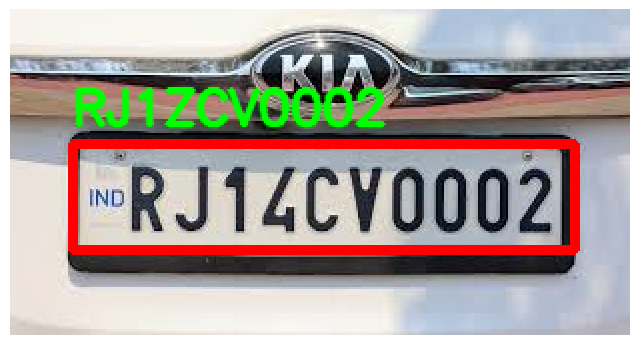

車牌 1: RJ1ZCV0002

image 1/1 /kaggle/input/test-licence/test5.jpg: 384x640 1 licence, 7.4ms
Speed: 1.5ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


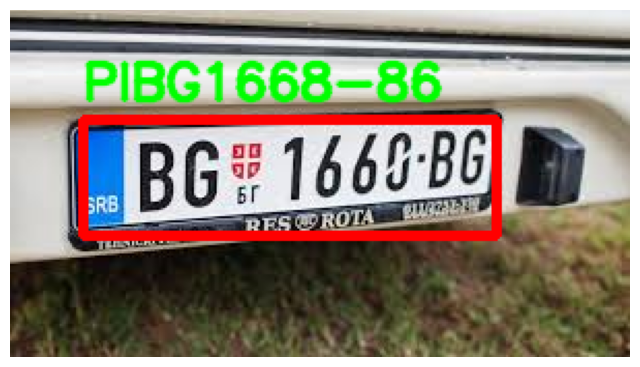

車牌 1: PIBG1668-86

image 1/1 /kaggle/input/test-licence/test2.png: 384x640 1 licence, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


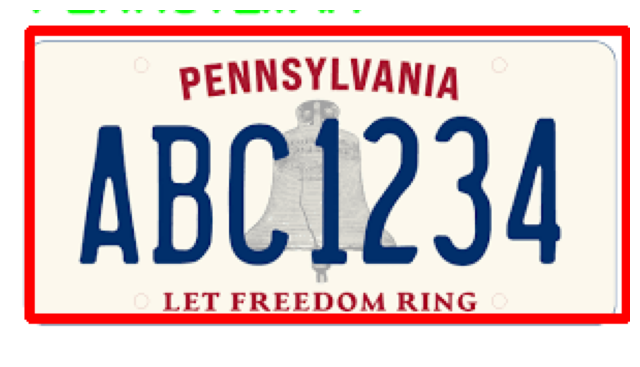

車牌 1: PEHHSYLIIFIA

image 1/1 /kaggle/input/test-licence/test1.jpg: 352x640 1 licence, 7.5ms
Speed: 1.6ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


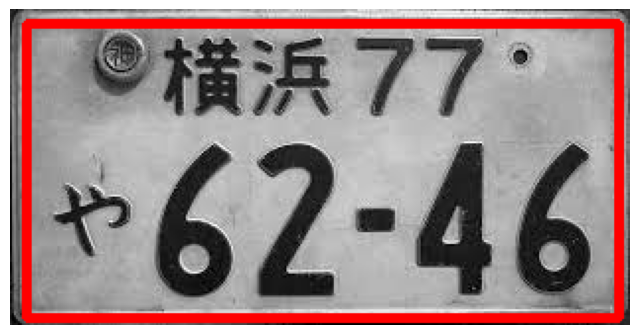

車牌 1: 262-46

image 1/1 /kaggle/input/test-licence/test3.png: 384x640 1 licence, 7.4ms
Speed: 1.5ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


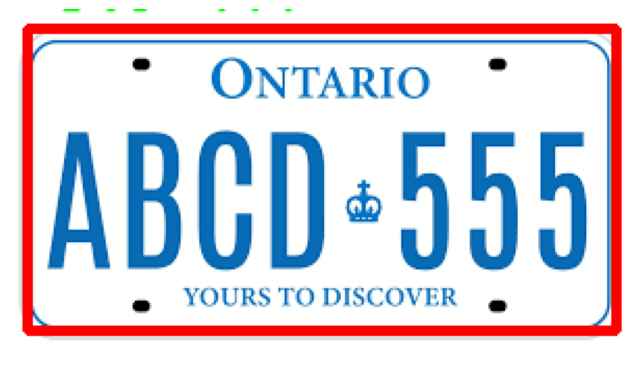

車牌 1: ABCD-555


In [41]:
from ultralytics import YOLO
import cv2
import easyocr
import pytesseract
import random
import glob
import matplotlib.pyplot as plt
import re

# 載入 YOLO 模型 (使用 train5 的最佳權重)
model = YOLO("runs/detect/train5/weights/best.pt")  # 使用 train5 模型的最佳權重

# 初始化 EasyOCR 和 Tesseract
reader = easyocr.Reader(['en', 'ch_tra'])  # EasyOCR 支援多語言
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"  # 設定 Tesseract 路徑（如果需要）

# 取得所有圖片路徑
image_paths = glob.glob("/kaggle/input/test-licence/*.png") + \
              glob.glob("/kaggle/input/test-licence/*.jpg")

# 隨機選擇圖片測試
num_images = min(10, len(image_paths))
random_images = random.sample(image_paths, num_images)

# 車牌字符過濾規則，只保留字母、數字、破折號（'-'）
def filter_plate_text(text):
    return re.sub(r'[^A-Za-z0-9-]', '', text).strip()

# 開始處理圖片
for img_path in random_images:
    # 讀取圖片
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉換為 RGB (避免顏色顛倒)

    # 使用 YOLO 進行車牌偵測
    results = model(img_path)

    # 儲存辨識的車牌文字
    detected_text_list = []  # 儲存所有偵測到的文字

    # 遍歷所有偵測到的結果 (results 是一個 list)
    for result in results:
        boxes = result.boxes  # 取得偵測到的所有邊界框
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].int().tolist()  # 取得邊界框座標
            conf = box.conf[0].item()  # 取得置信度
            cls = box.cls[0].item()  # 取得類別 (不需要用到，可以省略)

            # 擷取車牌區域
            plate_img = img[y1:y2, x1:x2]

            # 預處理：將車牌區域轉為灰度並進行二值化
            gray_plate_img = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
            enhanced_plate_img = cv2.convertScaleAbs(gray_plate_img, alpha=1.5, beta=0)
            _, binarized_plate_img = cv2.threshold(enhanced_plate_img, 150, 255, cv2.THRESH_BINARY)

            # 使用 EasyOCR 進行車牌文字辨識
            easyocr_results = reader.readtext(binarized_plate_img)

            # 使用 Tesseract 進行車牌文字辨識
            tess_text = pytesseract.image_to_string(binarized_plate_img, config='--psm 8')  # psm 8 是適合單行文字的模式

            # 取得兩者結果並過濾不需要的字符
            detected_text_easyocr = ""
            if easyocr_results:
                detected_text_easyocr = max(easyocr_results, key=lambda x: x[2])[1].upper()  # 取可信度最高的文字
                detected_text_easyocr = filter_plate_text(detected_text_easyocr)  # 過濾不符合的字符

            detected_text_tesseract = filter_plate_text(tess_text.strip())

            # 混合兩者結果：選擇可信度更高的結果
            detected_text = detected_text_easyocr if len(detected_text_easyocr) > len(detected_text_tesseract) else detected_text_tesseract

            # 繪製偵測框
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 3)  # 藍色框

            # 在圖片上顯示車牌辨識文字
            cv2.putText(img_rgb, detected_text, (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

            # 儲存文字結果
            detected_text_list.append(detected_text)

    # 顯示結果圖片
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

    # 顯示在圖片下方的車牌結果
    for i, text in enumerate(detected_text_list):
        print(f"車牌 {i+1}: {text}")  # 顯示車牌的辨識結果
